In [1]:
library(tidyverse)
library(cowplot)
library(corrplot)
library(modelr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

corrplot 0.88 loaded



In [2]:
options(repr.plot.width=20,repr.plot.height=10)

In [3]:
df <- read_csv("../input/insurance/insurance.csv")

Rows: 1338 Columns: 7

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): sex, smoker, region
dbl (4): age, bmi, children, charges


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



# **Functions**

In [4]:
plot_scatter <- function(data, x){
    ggplot(data, aes_string(x = x , y = data$charges))+
    geom_point()
}

plot_box <- function(data, x){
    ggplot(data, aes_string(x = x , y = data$charges, fill = x, group = x))+
    geom_boxplot()
}

# **EDA**

In [5]:
head(df, 5)

age,sex,bmi,children,smoker,region,charges
<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
19,female,27.900,0,yes,southwest,16884.924
18,male,33.770,1,no,southeast,1725.552
28,male,33.000,3,no,southeast,4449.462
33,male,22.705,0,no,northwest,21984.471
32,male,28.880,0,no,northwest,3866.855


* Continuous - age, bmi, charges.
* Discrete - sex, children, smoker, region.

# **Continuous variables in relation to the insurance premium**

In [6]:
plots.scatterplot <- lapply(colnames(df[,c(1,3)]),plot_scatter, data = df)

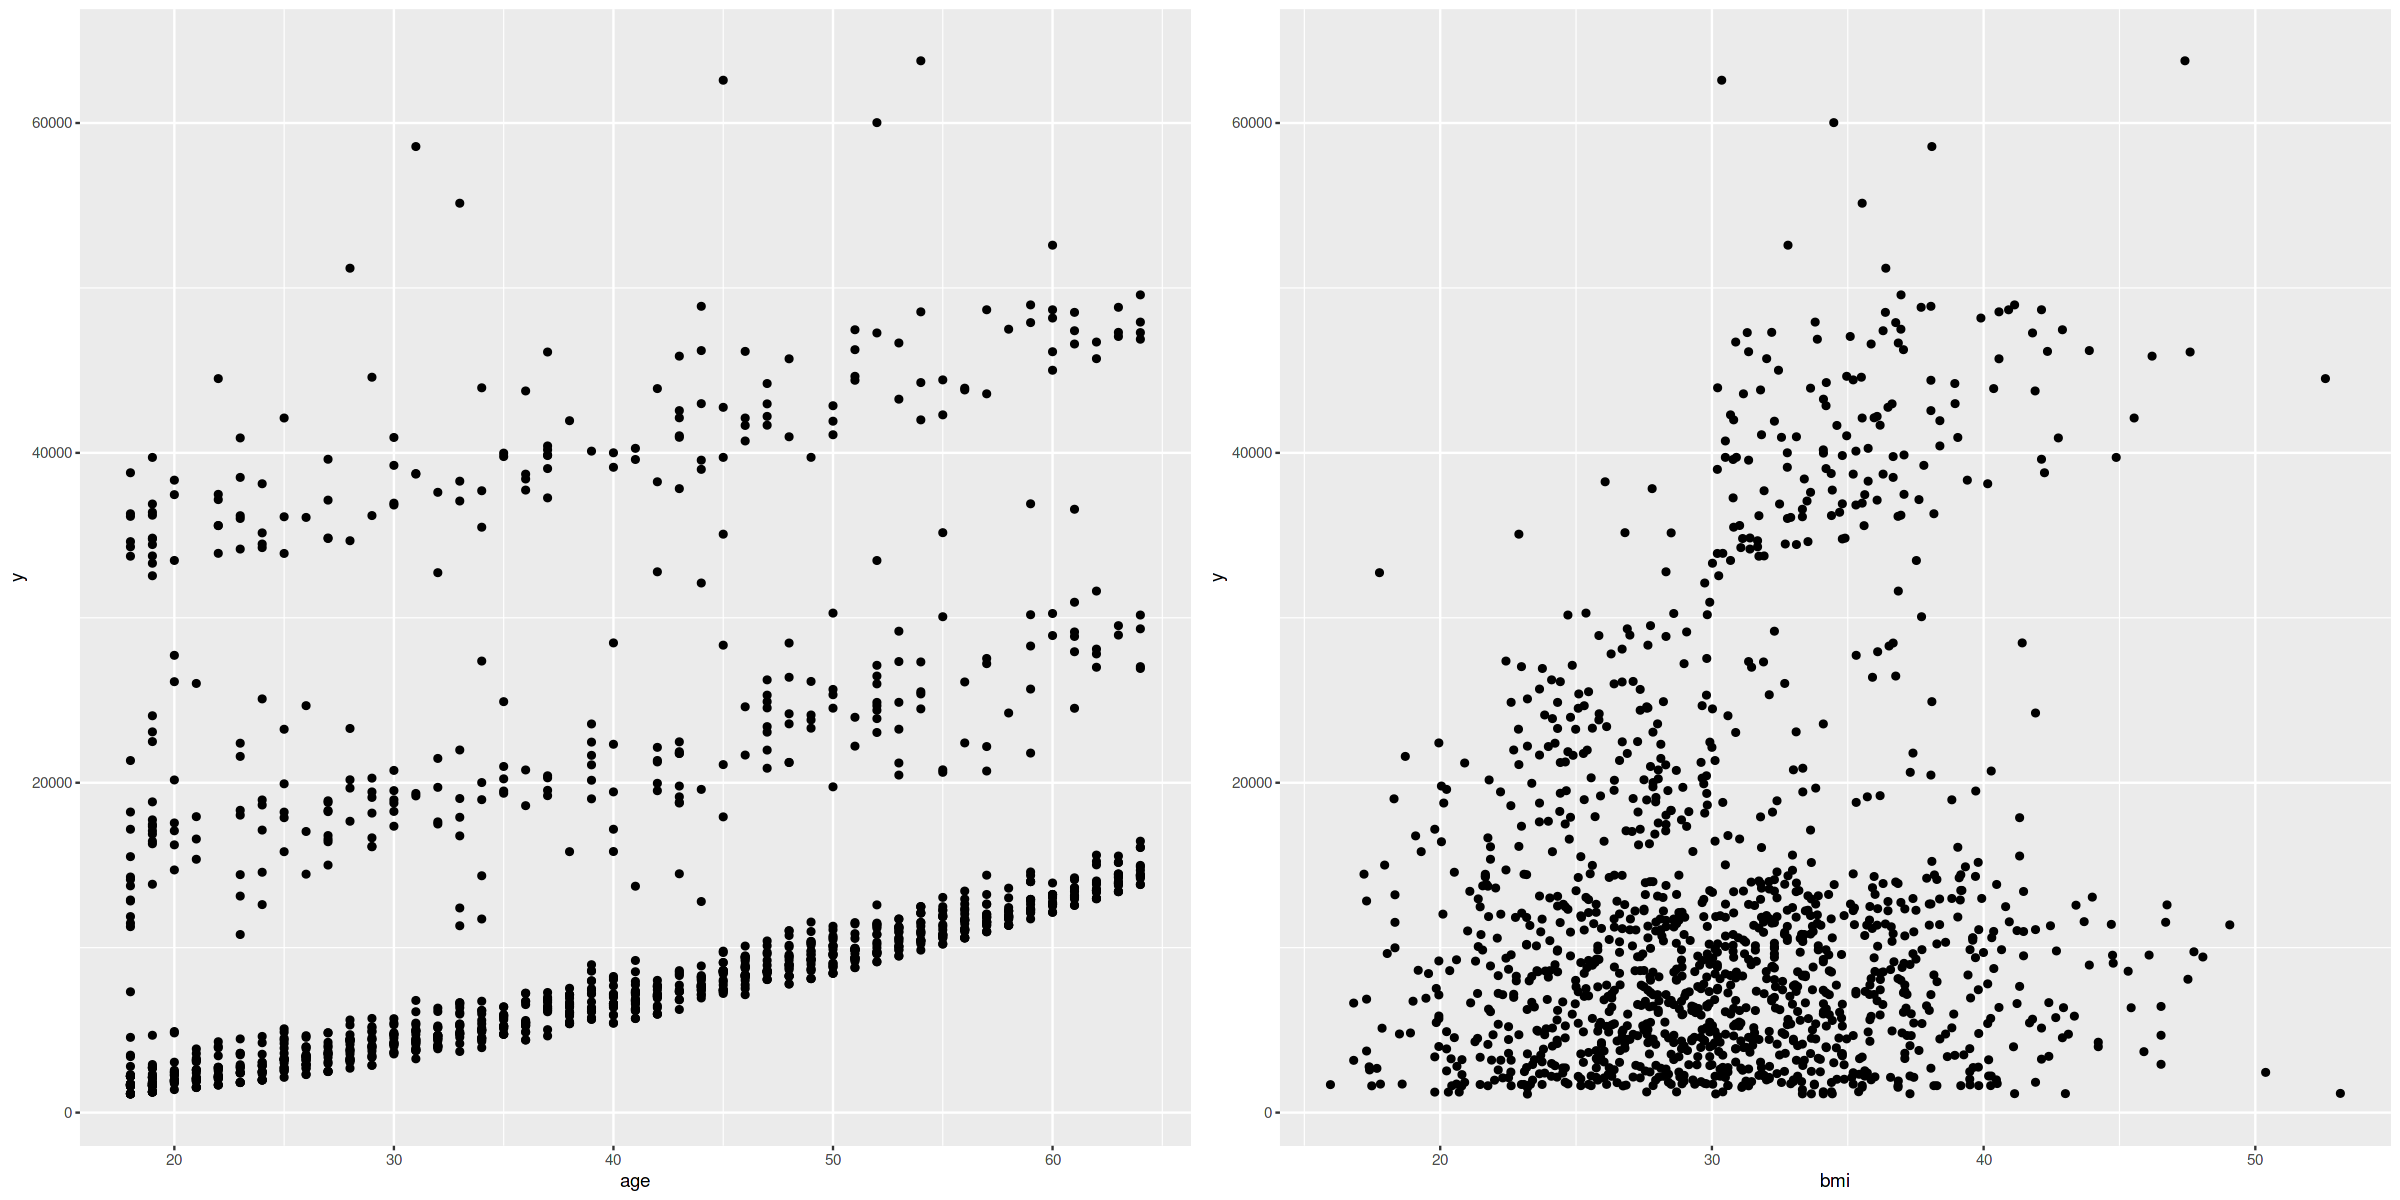

In [7]:
plot_grid(plotlist = plots.scatterplot)

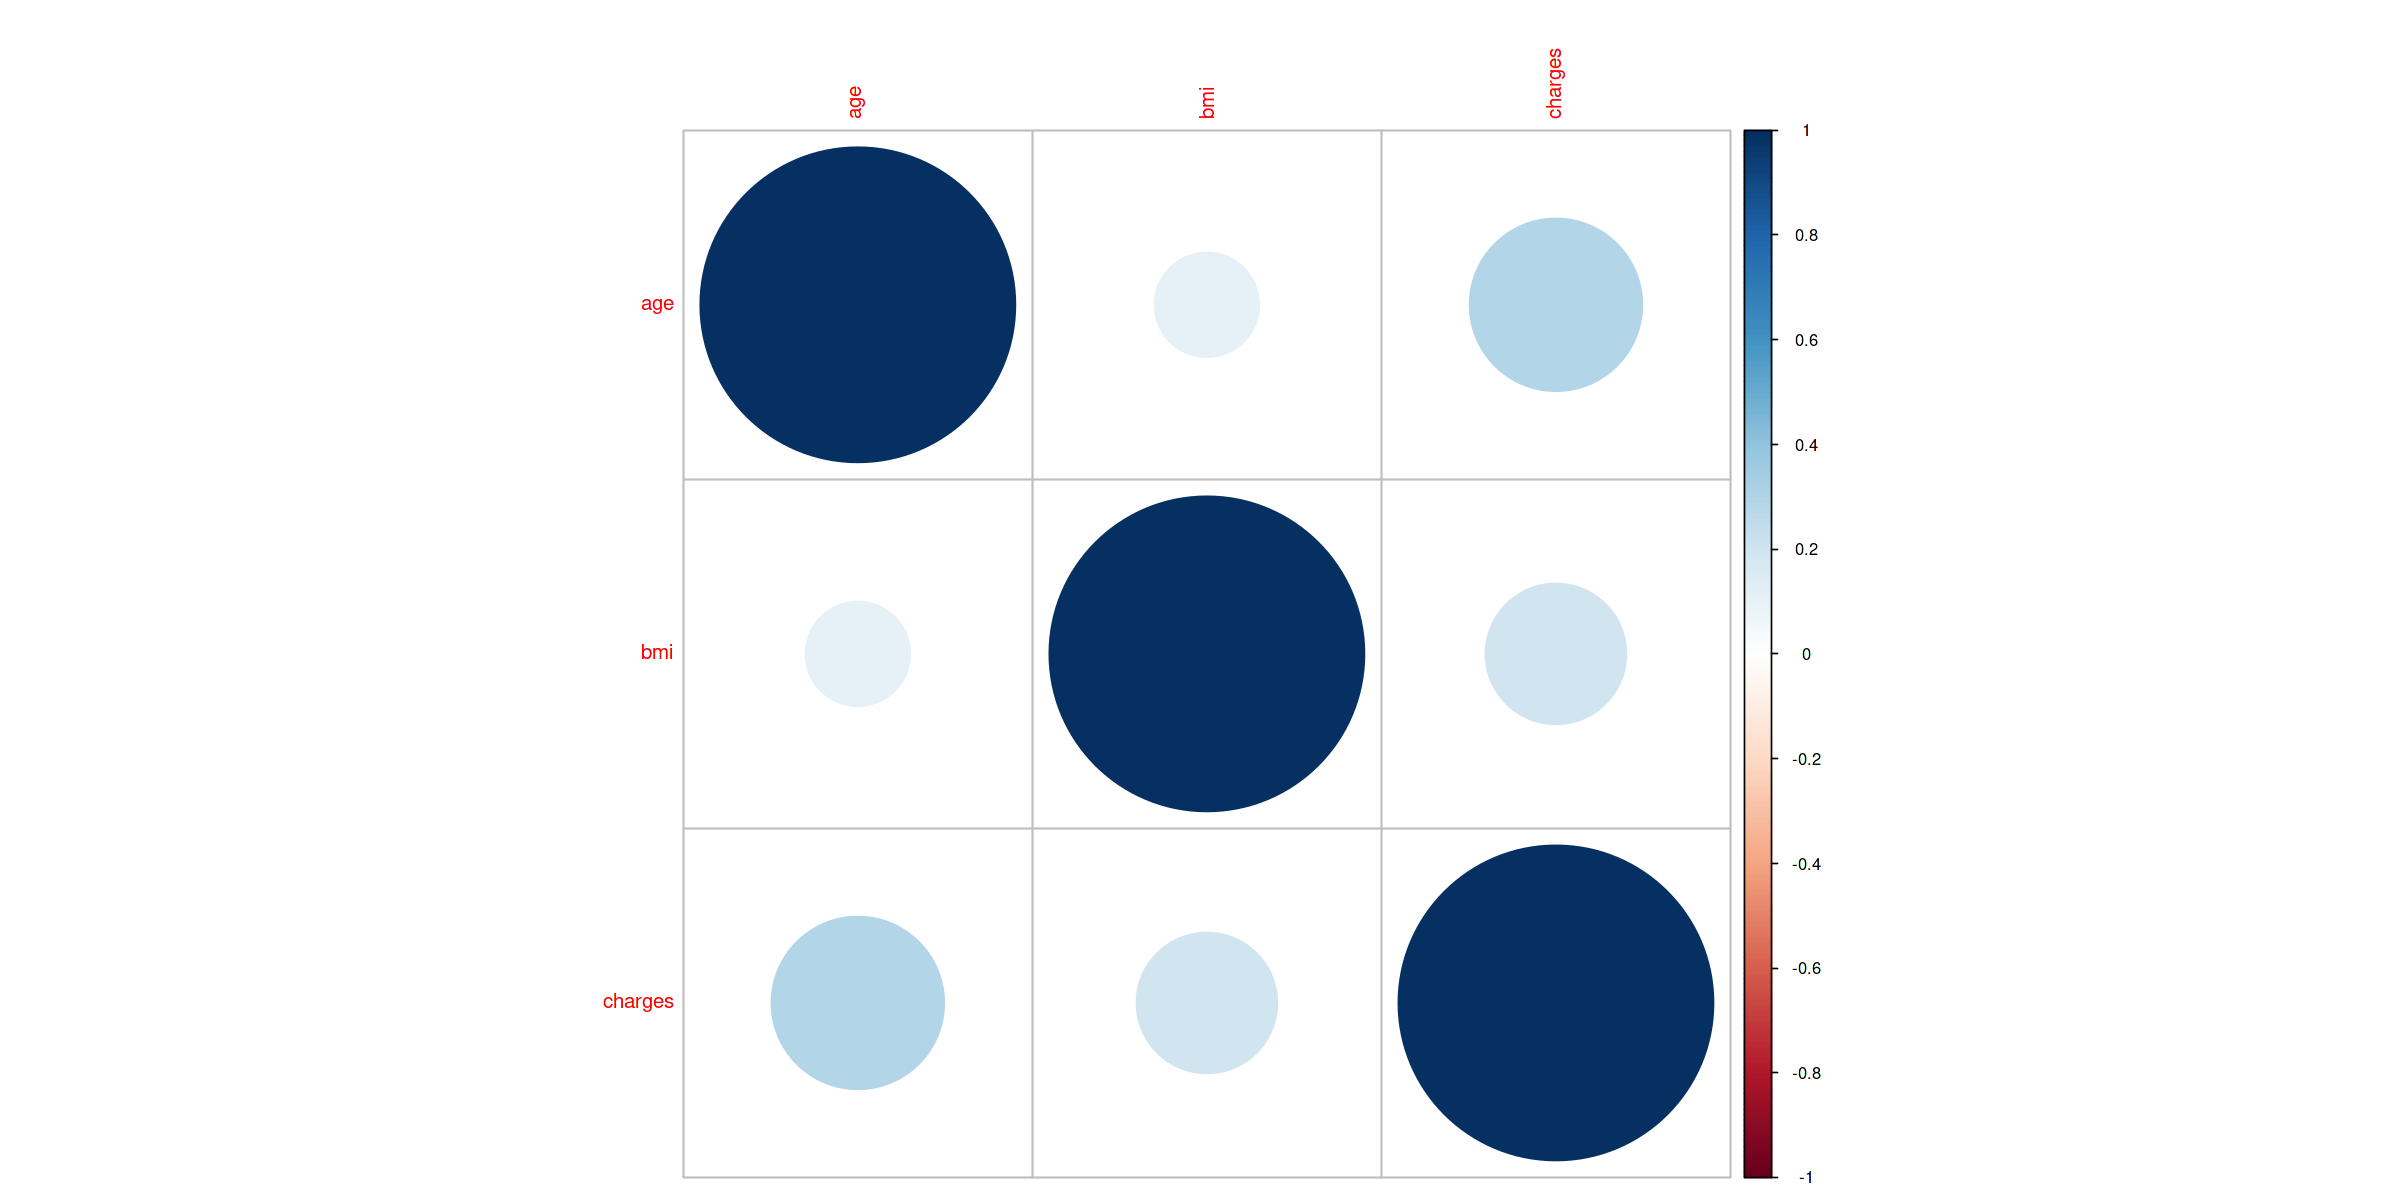

In [8]:
df.cor <- cor(df[,c(1,3,7)])
corrplot(df.cor)

* We can see that age does play a role in determining the insurance premium. The bmi does also a positive relationship, however it is less clear given that many of the data point are near zero.

# **Discrete variables in relation to the insurance premium**

In [9]:
plots.boxplot <- lapply(colnames(df[,c(-1,-3, -7)]),plot_box, data = df)

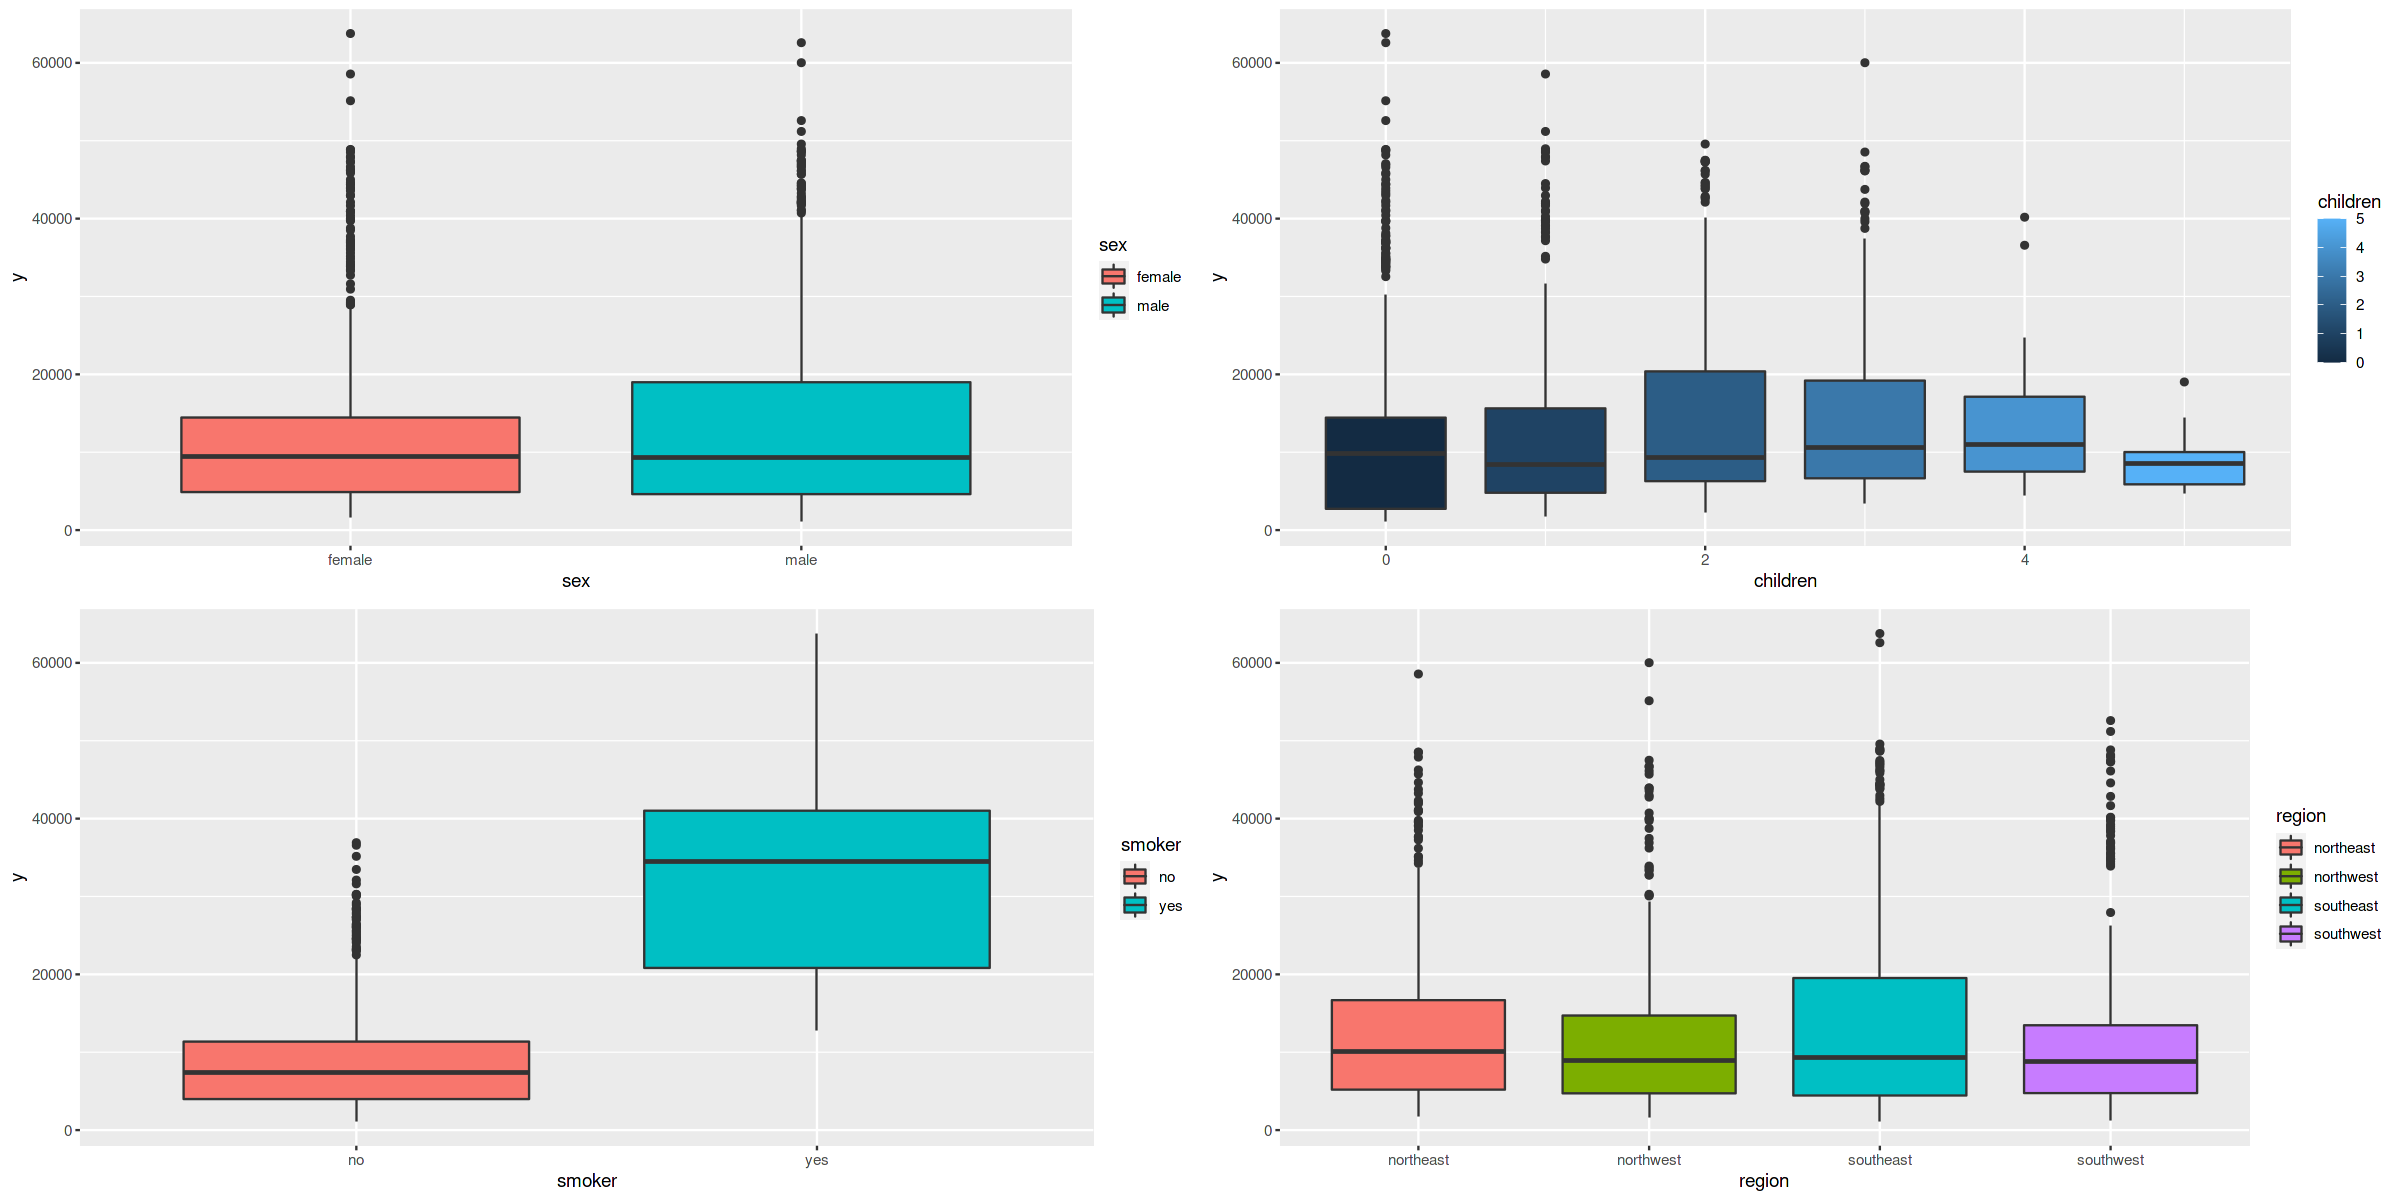

In [10]:
plot_grid(plotlist = plots.boxplot)

* We clearly see that people who smoker are charged with a higher insurance premium.  Like wise, we see a little increase in insurance premium when the number of children increases. But,decreases when their are 4 and more children which is surprising to see. A possible explanation for this result is in this [page](https://www.bcbsm.com/index/health-insurance-help/faqs/topics/buying-insurance/family-size-impact-cost.html#:~:text=When%20you%20add%20a%20spouse%20or%20child%20onto,21%2C%20you%20only%20pay%20for%20the%20three%20oldest.), where it states when "[a family has] more than three children under the age of 21, you only pay for the three oldest". Which effectively makes the policyholder with more than 4 children only have to pay premium for three children. Thus, we assume that the policyholders only has children that are under the age of 21 for this data.The sex and region variables seem to show no effect on the insurance premium.

In [11]:
df2 <- df%>%
    mutate(
        region2 = case_when(region == "northeast" ~ "east",
                            region == "northwest" ~ "west",
                            region == "southeast" ~ "east",
                            region == "southwest" ~ "west",
                           ),
        region3 = case_when(region == "northeast" ~ "north",
                            region == "northwest" ~ "north",
                            region == "southeast" ~ "south",
                            region == "southwest" ~ "south",
                          )
    )

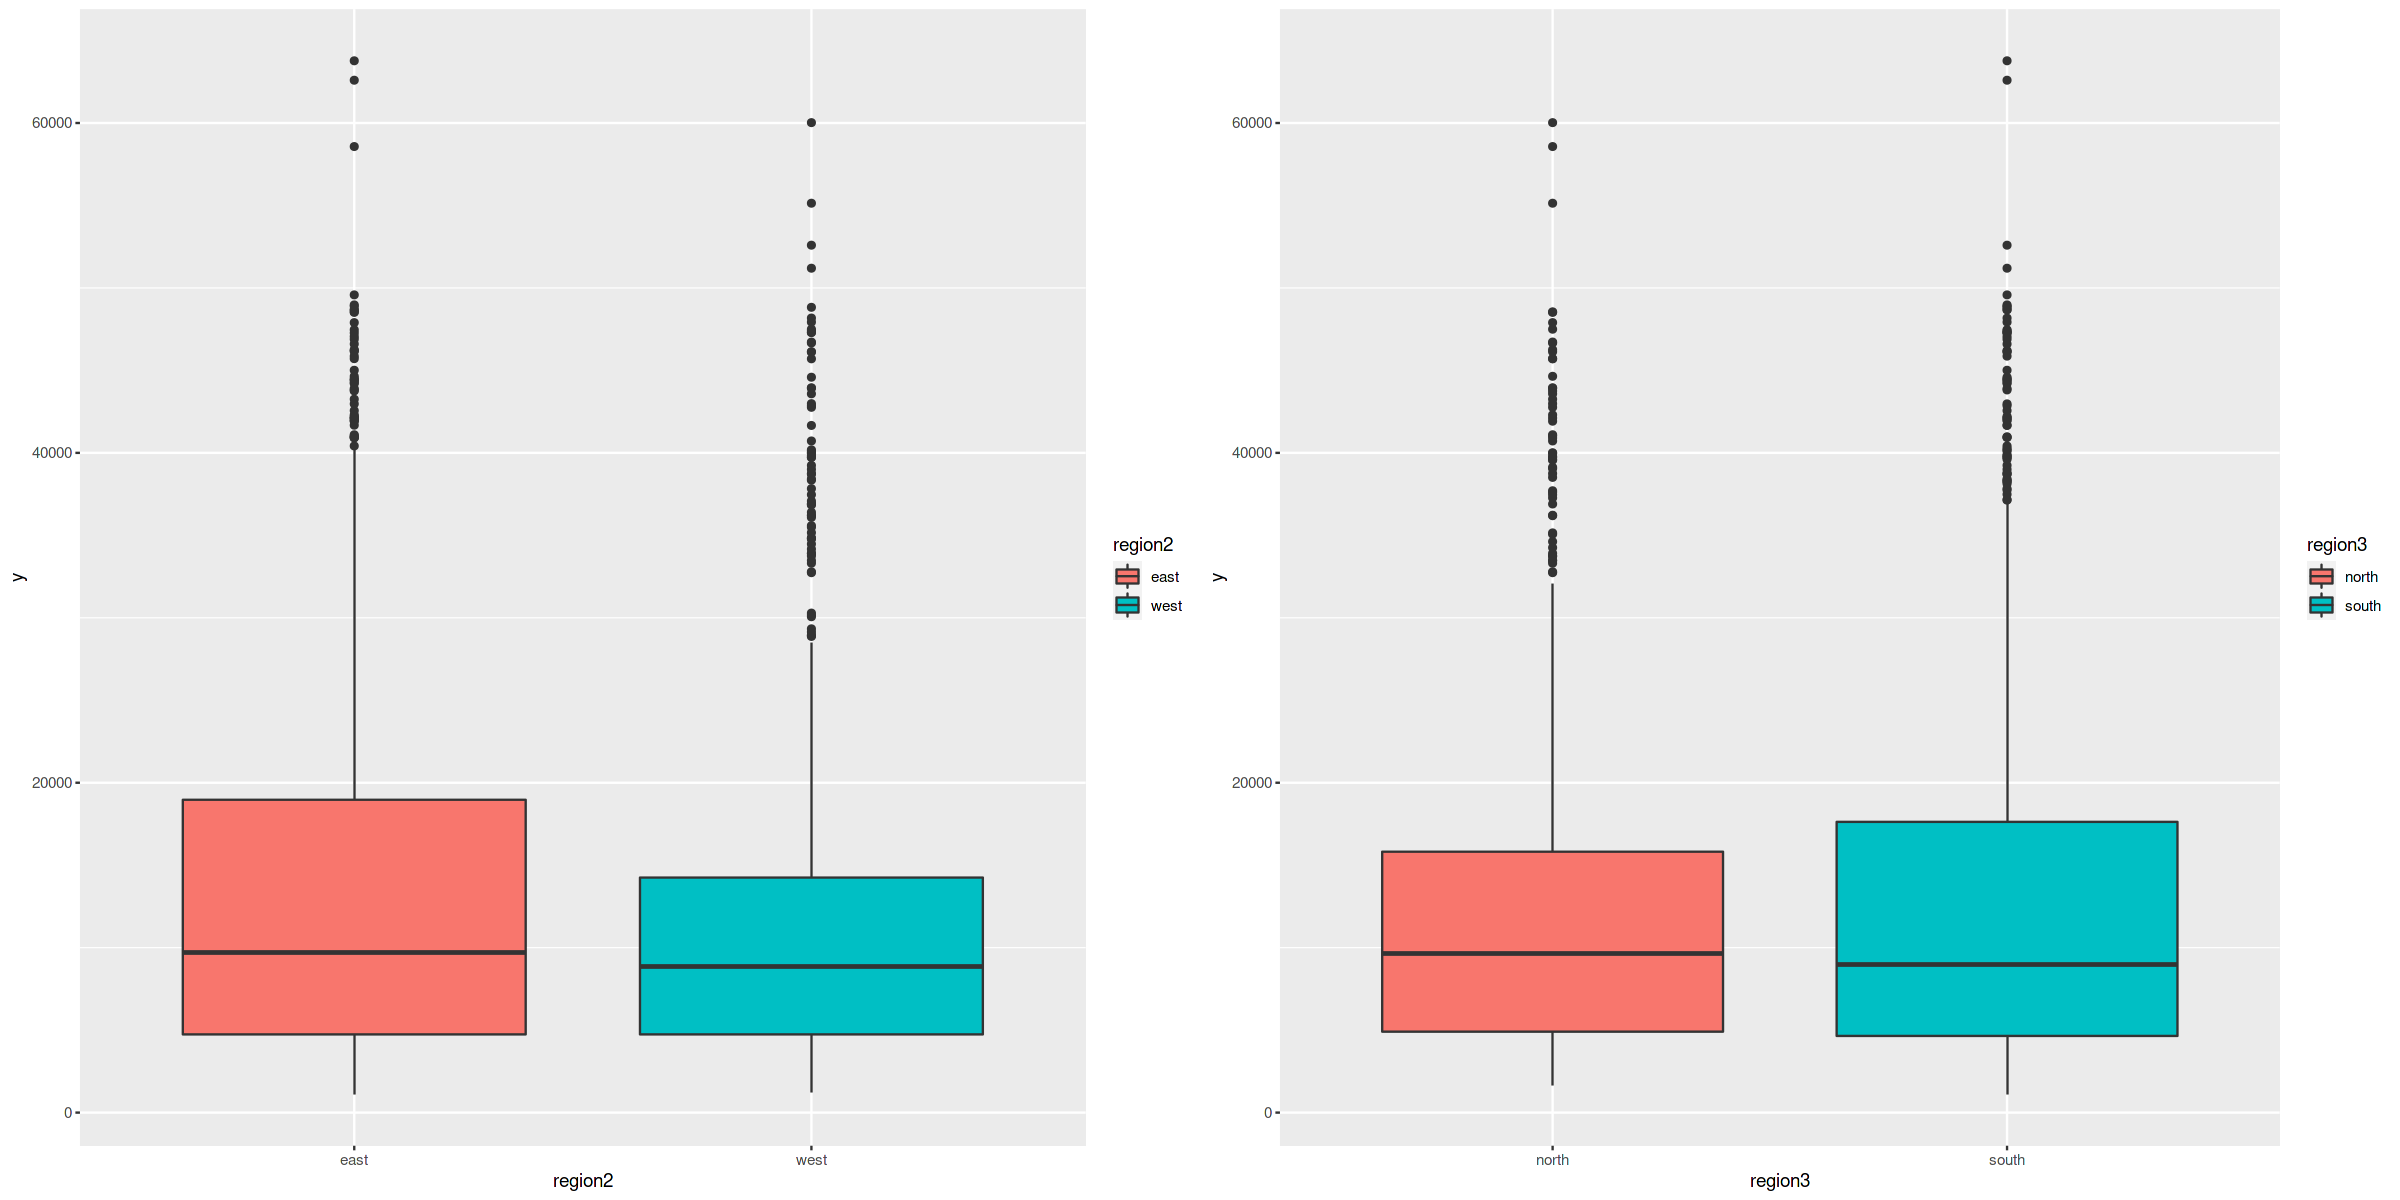

In [12]:
plots.boxplots2 <- lapply(colnames(df2[,c(8,9)]), plot_box, data = df2)
plot_grid(plotlist = plots.boxplots2 )

* Even transforming the region to "West/East" and "North/South", we still fail to see a strong relationship with region and insurance premium.

# **Modeling**

# **Dummy Encoding**

In [13]:
df.modeling <- df%>%
    mutate(
        sex = if_else(sex == "male", 1, 0),
        smoker = if_else(smoker == "yes", 1, 0),
        se = if_else(region == "southeast", 1 , 0),
        ne = if_else(region == "northeast", 1 , 0),
        nw = if_else(region == "northwest", 1 , 0),
        c1 = if_else(children == 1, 1, 0),
        c2 = if_else(children == 2, 1, 0),
        c3 = if_else(children == 3, 1, 0),
        c4 = if_else(children == 4, 1, 0),
        c5 = if_else(children == 5, 1, 0)
    )%>%
    select(-region, -children)
head(df.modeling, 5)

age,sex,bmi,smoker,charges,se,ne,nw,c1,c2,c3,c4,c5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,0,27.900,1,16884.924,0,0,0,0,0,0,0,0
18,1,33.770,0,1725.552,1,0,0,1,0,0,0,0
28,1,33.000,0,4449.462,1,0,0,0,0,1,0,0
33,1,22.705,0,21984.471,0,0,1,0,0,0,0,0
32,1,28.880,0,3866.855,0,0,1,0,0,0,0,0


* We will consider female, nonsmoker, southwest, and no children as our reference for the dummy encoding.

# **Data Splitting**

In [14]:
set.seed(123)
train <- sample(nrow(df.modeling), .70*nrow(df.modeling), replace = FALSE)

In [15]:
df.train <- df.modeling[train,]
df.test <- df.modeling[-train,]

# **Multiple Linear Regression**

In [16]:
model1 <- lm(charges ~ ., data = df.train)

In [17]:
summary(model1)


Call:
lm(formula = charges ~ ., data = df.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-11699.6  -2928.1   -932.4   1759.9  30285.0 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -13497.07    1279.81 -10.546  < 2e-16 ***
age            239.82      14.70  16.311  < 2e-16 ***
sex           -253.92     409.17  -0.621  0.53504    
bmi            367.20      34.91  10.517  < 2e-16 ***
smoker       23931.96     495.67  48.282  < 2e-16 ***
se             186.48     572.11   0.326  0.74454    
ne            1098.27     582.69   1.885  0.05977 .  
nw             502.55     583.84   0.861  0.38959    
c1             557.14     517.20   1.077  0.28167    
c2            1694.09     564.84   2.999  0.00278 ** 
c3            1675.18     671.68   2.494  0.01280 *  
c4            4488.39    1456.79   3.081  0.00212 ** 
c5            1936.98    1638.56   1.182  0.23746    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residua

* As expected, the sex and region variable shows no significance to the model. Even though the c1 and c5 shows no significance, we will keep it in the model given that majority of the variables show sigificance.

In [18]:
model2 <- lm(charges ~ . -sex -se -ne -nw, data = df.train)

In [19]:
summary(model2)


Call:
lm(formula = charges ~ . - sex - se - ne - nw, data = df.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-11832.1  -3073.3   -842.5   1801.9  29900.1 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -12728.52    1174.34 -10.839  < 2e-16 ***
age            240.49      14.69  16.367  < 2e-16 ***
bmi            351.84      33.22  10.590  < 2e-16 ***
smoker       23917.27     492.67  48.546  < 2e-16 ***
c1             533.91     517.00   1.033  0.30201    
c2            1664.80     564.75   2.948  0.00328 ** 
c3            1701.98     670.88   2.537  0.01135 *  
c4            4526.43    1454.78   3.111  0.00192 ** 
c5            1733.73    1632.92   1.062  0.28863    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6188 on 927 degrees of freedom
Multiple R-squared:  0.7475,	Adjusted R-squared:  0.7453 
F-statistic: 343.1 on 8 and 927 DF,  p-value: < 2.2e-16


* After removing the sex and region variable, the adjusted R2 is nearly equal to first model. This further shows these variable are useless when predicting the insurance premium. 

# **Prediction**

In [20]:
df.pred <- df.test%>%
    add_predictions(model2)%>%
    mutate(
        residual = charges - pred,
        residual_sq = (residual)^2
    )
head(df.pred, 5)

age,sex,bmi,smoker,charges,se,ne,nw,c1,c2,c3,c4,c5,pred,residual,residual_sq
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,0,27.900,1,16884.92,0,0,0,0,0,0,0,0,25574.37,-8689.442,75506397
33,1,22.705,0,21984.47,0,0,1,0,0,0,0,0,3196.23,18788.241,352997996
46,0,33.440,0,8240.59,1,0,0,1,0,0,0,0,10633.52,-2392.933,5726130
62,0,26.290,1,27808.73,1,0,0,0,0,0,0,0,35349.18,-7540.450,56858393
56,0,39.820,0,11090.72,1,0,0,0,0,0,0,0,14749.27,-3658.552,13385002


In [21]:
cat("The RMSE for the test data is",sqrt(sum(df.pred$residual_sq)/nrow(df.pred)))

The RMSE for the test data is 5824.681